In [27]:
import numpy as np 
import os 
import pandas as pd
import tensorflow
dir_path = './datasets/facial_recognition/'

train_dir = os.path.join(dir_path,'train.csv')
test_dir = os.path.join(dir_path,'test.csv')

In [2]:
train_csv = pd.read_csv(train_dir)
test_csv = pd.read_csv(test_dir)
train_csv.head()
train_csv.shape

(28709, 2)

In [3]:
split_df = pd.DataFrame([train_csv['pixels'][i].split() for i in range(train_csv.shape[0])])

In [4]:
train_joined = train_csv.join(split_df)

In [5]:
train_joined.drop('pixels',axis = 1,inplace = True)

In [6]:
Y_train = train_joined['emotion']

In [7]:
X_train = train_joined.iloc[:,1:2305]

In [8]:
import matplotlib
import matplotlib.pyplot as plt 

x_train_raw = X_train.to_numpy()
y_train_raw = Y_train.to_numpy()

x_train = x_train_raw.astype(np.float64)
y_train = y_train_raw.astype(np.int)

x_train/=255

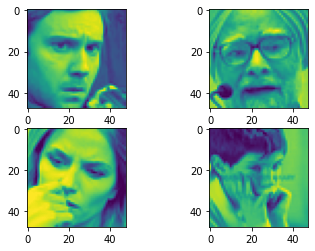

In [9]:
# Showing a couple of images taken from the train data set
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(x_train[0].reshape((48,48)))
ax2 = fig.add_subplot(222)
ax2.imshow(x_train[1].reshape((48,48)))
ax3 = fig.add_subplot(223)
ax3.imshow(x_train[2].reshape((48,48)))
ax4 = fig.add_subplot(224)
ax4.imshow(x_train[3].reshape((48,48)))
plt.show()

(array([3995.,  436., 4097., 7215., 8001.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

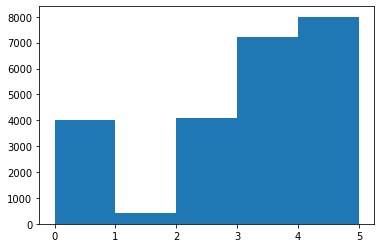

In [10]:
# Looking at the histogram of the emotions 
#plt.hist(range(len(np.unique(y_train))),y_train)

plt.hist(y_train_raw,range(6))

# Emotion nb 1 seems to be very underrepresented, 
# with that lack of data it is most likely we will perform poorly on recognizing those

In [11]:
print(x_train_raw.shape)
print(y_train_raw.shape)

(28709, 2304)
(28709,)


In [12]:
# We build a train/test data set
# We have a lot of data (overall) so we can afford to take a relatively large validation set
from sklearn.model_selection import train_test_split

x_train,x_val, y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2,stratify = y_train_raw)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(y_val.shape)

(22967, 2304)
(22967,)
(5742,)


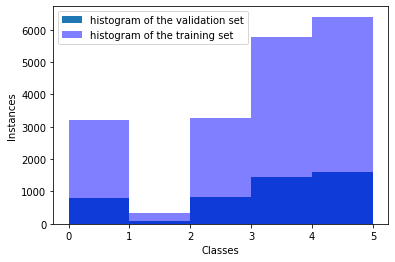

In [14]:
plt.hist(y_val,range(6),label='histogram of the validation set')
plt.hist(y_train,range(6),fc= (0,0,1,0.5),label='histogram of the training set')
plt.legend()
plt.xlabel('Classes')
plt.ylabel('Instances')
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [16]:
pred = rf.predict(x_val)

Accuracy of the random forest classifier : 0.4411354928596308


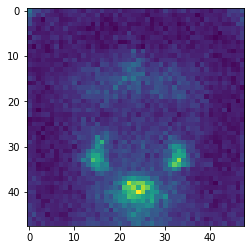

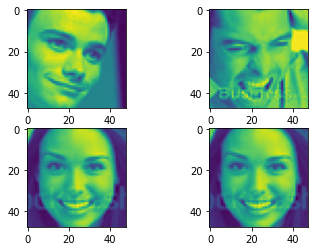

In [17]:
from sklearn.metrics import accuracy_score

score = accuracy_score(pred,y_val)
# 44 % Accuracy
print('Accuracy of the random forest classifier :',score)

# We have managed to get better than a random classifier (around 1/7)
# This is a good baseline model

# We use it to show the importance of the pixels 

fi = rf.feature_importances_
plt.imshow(np.reshape(fi,(48,48)))
plt.show()

# Showing a couple of images taken from the train data set
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(x_train[np.random.randint(15)].reshape((48,48)))
ax2 = fig.add_subplot(222)
ax2.imshow(x_train[np.random.randint(15)].reshape((48,48)))
ax3 = fig.add_subplot(223)
ax3.imshow(x_train[np.random.randint(15)].reshape((48,48)))
ax4 = fig.add_subplot(224)
ax4.imshow(x_train[np.random.randint(15)].reshape((48,48)))
plt.show()

Interesting fact, the model seems to look for clues mainly around the mouth, gives importance to the cheeks, and also a bit to the forehead. Pretty much what we do as humans ! 

In [18]:
# We will now train a convnet (duh) to tacke the problem

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [19]:
x_train = np.reshape(x_train,(x_train.shape[0],48,48,1))
x_val = np.reshape(x_val,(x_val.shape[0],48,48,1))

In [20]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# MODEL 1

In [144]:
import tensorflow
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu', padding = 'same',input_shape = (48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(7,activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 12, 12, 128)     

In [140]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_data = (x_val,y_val),epochs = 50, batch_size = 128)

Epoch 1/50
180/180 [==============================] - 4s 21ms/step - loss: 1.8269 - accuracy: 0.2465 - val_loss: 1.7966 - val_accuracy: 0.2541
Epoch 2/50
180/180 [==============================] - 4s 20ms/step - loss: 1.7892 - accuracy: 0.2541 - val_loss: 1.7856 - val_accuracy: 0.2499
Epoch 3/50
180/180 [==============================] - 4s 20ms/step - loss: 1.7141 - accuracy: 0.3039 - val_loss: 1.6472 - val_accuracy: 0.3490
Epoch 4/50
180/180 [==============================] - 4s 20ms/step - loss: 1.5994 - accuracy: 0.3685 - val_loss: 1.5235 - val_accuracy: 0.3988
Epoch 5/50
180/180 [==============================] - 4s 20ms/step - loss: 1.5174 - accuracy: 0.4118 - val_loss: 1.4441 - val_accuracy: 0.4333
Epoch 6/50
180/180 [==============================] - 4s 20ms/step - loss: 1.4557 - accuracy: 0.4337 - val_loss: 1.3938 - val_accuracy: 0.4613
Epoch 7/50
180/180 [==============================] - 4s 20ms/step - loss: 1.4036 - accuracy: 0.4566 - val_loss: 1.3546 - val_accuracy: 0.4794

In [166]:
# First model, only a bit better than the random forest 
# Lets see what's wrong with it

# A first obvious thing is the fact that is not complex enough to learn the training set
# We are quite obviously under fitting

# Lets try to make the model a bit more complex to make the hypothesis space larger 

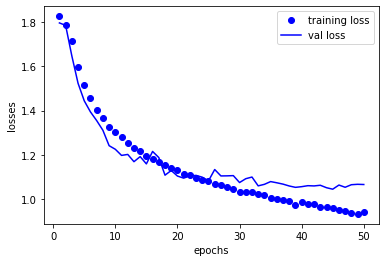

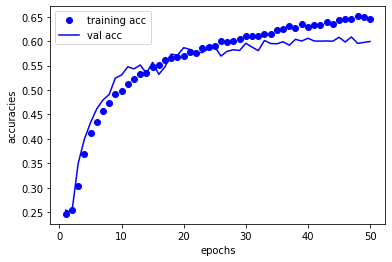

In [142]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()

plt.plot(epochs,acc,'bo',label='training acc')
plt.plot(epochs,val_acc,'b',label='val acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.show()


# MODEL 2 

In [21]:
model_2 = Sequential()

model_2.add(Conv2D(256,(3,3),activation = 'relu', padding = 'same',input_shape = (48,48,1)))
model_2.add(MaxPooling2D(2,2))
model_2.add(Dropout(0.3))


model_2.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model_2.add(MaxPooling2D(2,2))
model_2.add(Dropout(0.3))


model_2.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model_2.add(MaxPooling2D(2,2))
model_2.add(Dropout(0.3))


model_2.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model_2.add(MaxPooling2D(2,2))
model_2.add(Dropout(0.3))


model_2.add(Flatten())
model_2.add(Dense(256,activation='relu'))
model_2.add(Dense(256,activation='relu'))
model_2.add(Dense(7,activation='softmax'))
model_2.summary()

model_2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history = model_2.fit(x_train,y_train,validation_data = (x_val,y_val),epochs = 20, batch_size = 128,verbose=1)

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1)

plt.plot(epochs[1:],loss[1:],'bo',label='training loss')
plt.plot(epochs[1:],val_loss[1:],'b',label='val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()

plt.plot(epochs,acc,'bo',label='training acc')
plt.plot(epochs,val_acc,'b',label='val acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.show()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 256)       1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       1

KeyboardInterrupt: 

In [ ]:
# Batch norm helps a lot with accuracy, but makes the model more unstable during training
# The model also begins to overfit 
# I'd rather keep the overfitting model

# We will keep the model as it is, it is too long to train with a bigger one
# We could go tune it better, it juste starts to over fit 

# We now use a pretrained model, facenet

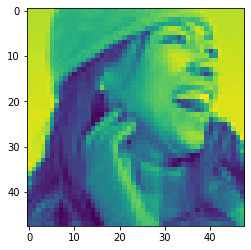

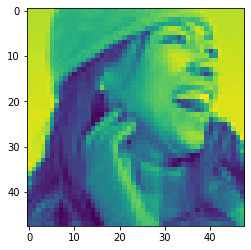

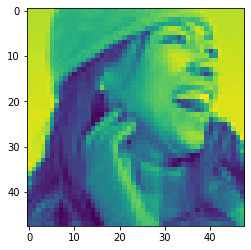

In [81]:
m_pre = Sequential()
from tensorflow.keras.applications import InceptionResNetV2

# Since ResNetV2 expects 3 input channels we repeat the image

x_train_3c = x_train[:,:,:,:,np.newaxis]
x_train_3c.shape
x_train_rgb = np.repeat(x_train, 3, -1)

plt.imshow(x_train_rgb[0,:,:,0].reshape(48,48))
plt.show()
plt.imshow(x_train_rgb[0,:,:,1].reshape(48,48))
plt.show()
plt.imshow(x_train_rgb[0,:,:,2].reshape(48,48))
plt.show()

x_val_rgb = np.repeat(x_val,3,-1)

# It worked

In [83]:
print(x_val_rgb.shape)
print(x_train_rgb.shape)

(5742, 48, 48, 3)
(22967, 48, 48, 3)


In [87]:
conv_base = InceptionResNetV2(include_top = False,weights ='imagenet')

In [88]:
conv_base.trainable = False

In [103]:
model = Sequential()
model.add(tensorflow.keras.layers.ZeroPadding2D((75,75), input_shape = (48,48,3)))

In [104]:
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation ='relu'))
model.add(Dense(7,activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',metrics = ['accuracy'],loss='categorical_crossentropy')

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin (None, 198, 198, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
flatten_3 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               3145856   
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 903       
Total params: 57,483,495
Trainable params: 3,146,759
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
history = model.fit(x_train_rgb,y_train, validation_data = (x_val_rgb,y_val), epochs = 20, batch_size = 256)

In [ ]:
# the model is very, very long to train, and I don't have the ressources to experiment on it, so we'll keep the handmade one

# Evaluation



In [23]:
# We train the model on the validation + training data set

In [23]:
x_train_full = np.concatenate((x_train,x_val))

In [24]:
y_train_full = np.concatenate((y_train,y_val))
y_train_full.shape

(28709, 7)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 256)       2560      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 256)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 256)       1638656   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 256)      

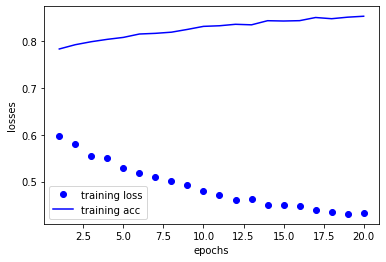

In [115]:
model = Sequential()

model.add(Conv2D(256,(3,3),activation = 'relu', padding = 'same',input_shape = (48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))


model.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))


model.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))


model.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(7,activation='softmax'))
model.summary()



In [33]:
full = os.path.join(dir_path, 'icml_face_data.csv')

full_csv = pd.read_csv(full)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [64]:
cop[full_csv['Usage'] != 'Training']

28709     PublicTest
28710     PublicTest
28711     PublicTest
28712     PublicTest
28713     PublicTest
            ...     
35882    PrivateTest
35883    PrivateTest
35884    PrivateTest
35885    PrivateTest
35886    PrivateTest
Name: Usage, Length: 7178, dtype: object

In [66]:
testing_csv = full_csv[full_csv['Usage'] == 'PublicTest']
private_csv = full_csv[full_csv['Usage'] == 'PrivateTest']

In [78]:
testing_csv.drop('Usage',axis=1,inplace=True)
private_csv.drop('Usage',axis=1,inplace=True)

/home/omar/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [86]:
testing_csv.reset_index(inplace=True)
private_csv.reset_index(inplace=True)

In [105]:
def convert_tests(df):
    
    # We plit the data set 
    split_df_test = pd.DataFrame([df['pixels'][i].split() for i in range(df.shape[0])])
    temp_joined = df.join(split_df_test)
    
    # We drop the pixels column
    temp_joined.drop('pixels',axis = 1,inplace = True)
    
    # We get the X : pixels 
    X = temp_joined.iloc[:,1:2305]
    x_raw = X.to_numpy()
    x = x_raw.astype(np.float64)
    x/=255

    # We get the Y : labels
    Y = temp_joined['emotion']
    y_raw = Y.to_numpy()
    y = y_raw.astype(np.int)
    y = to_categorical(y)

    x = np.reshape(x,(x.shape[0],48,48,1))
    
    print('Shape of attributes matrix',x.shape)
    print('Shape of label matrix',y.shape)
    
    return x,y

In [106]:
x_public, y_public = convert_tests(testing_csv)
x_private,y_private = convert_tests(private_csv)

Shape of attributes matrix (3589, 48, 48, 1)
Shape of label matrix (3589, 7)
Shape of attributes matrix (3589, 48, 48, 1)
Shape of label matrix (3589, 7)


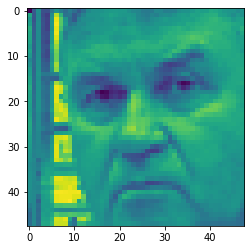

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [117]:
plt.imshow(x_public[2].reshape(48,48))
plt.show()
y_public[2]

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 12, 12, 128)     

225/225 [==============================] - 4s 18ms/step - loss: 0.9332 - accuracy: 0.6482
Epoch 55/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9256 - accuracy: 0.6521
Epoch 56/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9321 - accuracy: 0.6480
Epoch 57/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9248 - accuracy: 0.6548
Epoch 58/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9312 - accuracy: 0.6497
Epoch 59/150
225/225 [==============================] - 4s 19ms/step - loss: 0.9178 - accuracy: 0.6557
Epoch 60/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9172 - accuracy: 0.6560
Epoch 61/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9133 - accuracy: 0.6555
Epoch 62/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9175 - accuracy: 0.6563
Epoch 63/150
225/225 [==============================] - 4s 18ms/step - loss: 0.9079 - 

225/225 [==============================] - 4s 19ms/step - loss: 0.8400 - accuracy: 0.6865
Epoch 134/150
225/225 [==============================] - 4s 19ms/step - loss: 0.8417 - accuracy: 0.6905
Epoch 135/150
225/225 [==============================] - 4s 19ms/step - loss: 0.8441 - accuracy: 0.6871
Epoch 136/150
225/225 [==============================] - 5s 22ms/step - loss: 0.8325 - accuracy: 0.6918
Epoch 137/150
225/225 [==============================] - 5s 22ms/step - loss: 0.8478 - accuracy: 0.6906
Epoch 138/150
225/225 [==============================] - 5s 22ms/step - loss: 0.8410 - accuracy: 0.6914
Epoch 139/150
225/225 [==============================] - 5s 22ms/step - loss: 0.8343 - accuracy: 0.6945
Epoch 140/150
225/225 [==============================] - 5s 22ms/step - loss: 0.8420 - accuracy: 0.6895
Epoch 141/150
225/225 [==============================] - 4s 19ms/step - loss: 0.8373 - accuracy: 0.6914
Epoch 142/150
225/225 [==============================] - 4s 20ms/step - loss: 

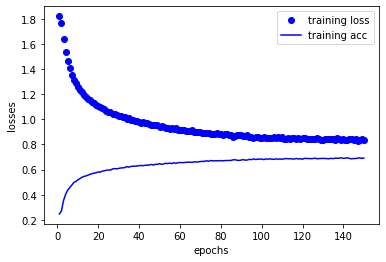

In [154]:
import tensorflow
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu', padding = 'same',input_shape = (48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(7,activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(x_train_full,y_train_full,epochs = 150, batch_size = 128)

loss = history.history['loss']

acc = history.history['accuracy']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,acc,'b',label='training acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()

In [158]:
model.evaluate(x_private,y_private)

113/113 [==============================] - 1s 5ms/step - loss: 1.0188 - accuracy: 0.6241


[1.018799066543579, 0.6241292953491211]

# My Model Accuracy : 62.41 % (10/58)

In [159]:
model.save('model_facial_recognition.h5')